In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

sns.set_context('talk')

## set random seed
RND = 722

**Note:**

Data source: [hotel demand datasets](https://ars.els-cdn.com/content/image/1-s2.0-S2352340918315191-mmc2.zip) from Antonio, et al. (2019).

Paper: Antonio, N., De Almeida, A., & Nunes, L. (2019). Hotel booking demand datasets. Data in Brief, 22, 41-49. https://doi.org/10.1016/j.dib.2018.11.126

In [2]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('data-mining-iter1').getOrCreate()

/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/cloudpickle.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if obj.__module__ is "__builtin__":


We load the transformed data from `1-data-preparation-datatransformation.ipynb`.

# 5. Data Mining Method Selection

Supervised learning: classification task.


# 6. Data Mining Algorithm Selection

- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosted Tree

# 7. Data Mining

## 7.1. Create and Justify Test Designs

Train-validation-test. Use k-fold cross validation to estimate the performance in validation set.

We use similar train-test data as we used in feature selection and random oversampling.

In [3]:
import json
from pyspark.sql.types import StructType

## Get schema of the JSON file
with open("hotel_merged_data_transformation_schema.json") as f:
    new_schema = StructType.fromJson(json.load(f))

In [4]:
## Read the JSON file based on the saved schema
df_hotel = spark.read.json('hotel_merged_data_transformation.json/',
                          schema = new_schema)

In [5]:
## recheck number of observations
df_hotel.count()

141012

In [6]:
df_hotel.printSchema()

root
 |-- IsCanceled: integer (nullable = true)
 |-- LeadTime: double (nullable = true)
 |-- ArrivalDateWeekNumber: integer (nullable = true)
 |-- ArrivalDateDayOfMonth: integer (nullable = true)
 |-- StaysInWeekendNights: integer (nullable = true)
 |-- StaysInWeekNights: integer (nullable = true)
 |-- Adults: integer (nullable = true)
 |-- IsRepeatedGuest: boolean (nullable = true)
 |-- PreviousCancellations: integer (nullable = true)
 |-- PreviousBookingsNotCanceled: integer (nullable = true)
 |-- DaysInWaitingList: integer (nullable = true)
 |-- ADR: double (nullable = true)
 |-- HasChild: boolean (nullable = true)
 |-- RequireCarPark: boolean (nullable = true)
 |-- HasSpecialRequest: boolean (nullable = true)
 |-- IsReservedRoomTypeEqualToAssigned: boolean (nullable = true)
 |-- IsCityHotel: boolean (nullable = true)
 |-- MealVector: vector (nullable = true)
 |-- MarketSegmentVector: vector (nullable = true)
 |-- DistributionChannelVector: vector (nullable = true)
 |-- DepositTypeV

In [7]:
## split the dataframe based on previous train-test-split
df_train = df_hotel.filter('IsTestSet == False').drop('IsTestSet')
df_test = df_hotel.filter('IsTestSet == True').drop('IsTestSet')

## 7.2. Conduct Data Mining

Algorithms:
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient-Boosted Tree

These models are evaluated based on accuracy and AUC.


In [8]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

def kfold_cv(spark_df,
             target_colname, 
             clf,
             k = 10,
             random_seed = 722,
             eval_metric = 'accuracy',
             raw_prediction_colname = 'rawPrediction'
            ):
    """
    Perform k-fold cross-validation using the specified classifier.
    Return the cross-validated model.
    """
    params = ParamGridBuilder().build()

    assembler = VectorAssembler(
        inputCols = [colname for colname in spark_df.columns if (colname != target_colname)],
        outputCol = 'features'
    )

    pipeline = Pipeline(
        stages = [assembler, clf]
    )

    cv_binary = CrossValidator(
        estimator = pipeline,
        estimatorParamMaps = params,
        evaluator = BinaryClassificationEvaluator(
            labelCol = target_colname, 
            rawPredictionCol = raw_prediction_colname,
            metricName = 'areaUnderROC'
        ),
        numFolds = k,
        seed = random_seed
    )
    
    cv_multi = CrossValidator(
        estimator = pipeline,
        estimatorParamMaps = params,
        evaluator = MulticlassClassificationEvaluator(
            labelCol = target_colname, 
            metricName = eval_metric
        ),
        numFolds = k,
        seed = random_seed
    )
    
    ## Same model, but different evaluator
    ## We only want to store the average value of the evaluation metrics
    cv_model_binary = cv_binary.fit(spark_df)
    cv_model_multi = cv_multi.fit(spark_df)
    
    print("Cross-validation results")
    print("========================")
    print("AUC: {}".format(cv_model_binary.avgMetrics[0]))
    print("Accuracy: {}".format(cv_model_multi.avgMetrics[0]))
    
    ## Only return one model (both are similar)
    return cv_model_binary

In [9]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

def evaluate_performance(clf, spark_df, target_colname, raw_prediction_colname = 'rawPrediction'):
    """
    Evaluate model performance on the given dataset.
    Return the AUC and accuracy.
    """
    binary_evaluator = BinaryClassificationEvaluator(
        labelCol = target_colname,
        rawPredictionCol = raw_prediction_colname
    )
    multi_evaluator = MulticlassClassificationEvaluator(
        labelCol = target_colname,
        metricName = 'accuracy'
    )
    
    pred_df = clf.transform(spark_df)
    print("AUC: {}".format(binary_evaluator.evaluate(pred_df)))
    print("Accuracy: {}".format(multi_evaluator.evaluate(pred_df)))

### Logistic Regression

In [10]:
from pyspark.ml.pipeline import PipelineModel
from os import path
from pyspark.ml.classification import LogisticRegression

## If model has been trained, read pickled model via pipeline api
## If not, train the model and store the pickled model
LOGRES_MODEL_PATH = 'model/logistic_regression_iter1/'

if path.exists(LOGRES_MODEL_PATH):
    cv_logres = PipelineModel.load(LOGRES_MODEL_PATH)
else:
    logres = LogisticRegression(maxIter = 10, labelCol = 'IsCanceled')
    cv_logres = kfold_cv(df_train, target_colname = 'IsCanceled', clf = logres, k = 5)
    ## Save trained model
    cv_logres.bestModel.save(LOGRES_MODEL_PATH)

In [12]:
## On test set
evaluate_performance(cv_logres, df_test, target_colname = 'IsCanceled')

AUC: 0.8659261022206844
Accuracy: 0.7812648863731891


In [14]:
# ## sample: plot ROC curve -- available on logistic regression model, but not other models like Decision Tree, RF
# ## solution: https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
# d = cv_logres.bestModel.stages[-1].summary.roc.toPandas()
# sns.lineplot(
#     x = d['FPR'],
#     y = d['TPR']
# )
# sns.despine();

### Decision Tree

In [15]:
from pyspark.ml.pipeline import PipelineModel
from os import path
from pyspark.ml.classification import DecisionTreeClassifier

DTREE_MODEL_PATH = 'model/decision_tree_iter1/'

if path.exists(DTREE_MODEL_PATH):
    cv_dtree = PipelineModel.load(DTREE_MODEL_PATH)
else:
    dtree = DecisionTreeClassifier(labelCol = 'IsCanceled', seed = RND)
    cv_dtree = kfold_cv(df_train, target_colname = 'IsCanceled', clf = dtree, k = 5)
    ## save model
    cv_dtree.bestModel.save(DTREE_MODEL_PATH)

In [17]:
## On test set
evaluate_performance(cv_dtree, df_test, target_colname = 'IsCanceled')

AUC: 0.7953662469918492
Accuracy: 0.8044666124919438


### Random Forest

In [18]:
from pyspark.ml.pipeline import PipelineModel
from os import path
from pyspark.ml.classification import RandomForestClassifier

RF_MODEL_PATH = 'model/random_forest_iter1/'

if path.exists(RF_MODEL_PATH):
    cv_rf = PipelineModel.load(RF_MODEL_PATH)
else:
    rf = RandomForestClassifier(labelCol = 'IsCanceled', numTrees = 10, seed = RND)
    cv_rf = kfold_cv(df_train, target_colname = 'IsCanceled', clf = rf, k = 5)
    ## save model
    cv_rf.bestModel.save(RF_MODEL_PATH)

In [20]:
## On test set
evaluate_performance(cv_rf, df_test, target_colname = 'IsCanceled')

AUC: 0.8593754117640103
Accuracy: 0.7632751422086475


### Gradient Boosted Tree

Note: current GBTClassifier implementation in Pyspark does not return `rawPrediction` and `probability` as the output.

In [21]:
from pyspark.ml.pipeline import PipelineModel
from os import path
from pyspark.ml.classification import GBTClassifier

GBT_MODEL_PATH = 'model/gbt_iter1/'

if path.exists(GBT_MODEL_PATH):
    cv_gbt = PipelineModel.load(GBT_MODEL_PATH)
else:
    gbt = GBTClassifier(labelCol = 'IsCanceled', seed = RND, maxIter = 10)
    cv_gbt = kfold_cv(
        df_train, 
        target_colname = 'IsCanceled',
        clf = gbt, 
        k = 5,
        raw_prediction_colname = 'prediction'
    )
    ## save model
    cv_gbt.bestModel.save(GBT_MODEL_PATH)

In [23]:
## On test set
evaluate_performance(cv_gbt, df_test, target_colname = 'IsCanceled', raw_prediction_colname = 'prediction')

AUC: 0.7776595744680851
Accuracy: 0.8153669403424216


## 7.3. Search for Patterns

In [24]:
## store the feature list, so that we can extract them
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols = [colname for colname in df_train.columns if (colname != 'IsCanceled')],
    outputCol = 'features'
)

df_train_assembled = assembler.transform(df_train)

In [25]:
def get_feature_importance_score(feature_importance, spark_df, feature_colname):
    """
    Extract feature importance scores and combine them with the feature name.
    """
    attributes_dict = spark_df.schema[feature_colname].metadata["ml_attr"]["attrs"]
    attributes_list = []
    
    for key in attributes_dict:
        attributes_list = attributes_list + attributes_dict[key]
    
    df_attributes = pd.DataFrame(attributes_list)
    df_attributes['score'] = df_attributes['idx'].apply(lambda x: feature_importance[x])
    df_attributes = df_attributes.sort_values(
        'score', 
        ascending = False
    ).drop(
        labels = 'idx', 
        axis = 1
    )
    
    return df_attributes

In [26]:
def plot_feature_importance_score(df,
                                  feature_name_col='name',
                                  feature_score_col='score', 
                                  xlabel='feature importance'):
    f, ax = plt.subplots(figsize = (14,12))
    sns.barplot(
        data = df,
        y = feature_name_col,
        x = feature_score_col,
        orient = 'h',
        palette = 'magma',
        ax = ax
    );

    plt.xlabel(xlabel)
    plt.ylabel('')
    sns.despine();

### Logistic Regression

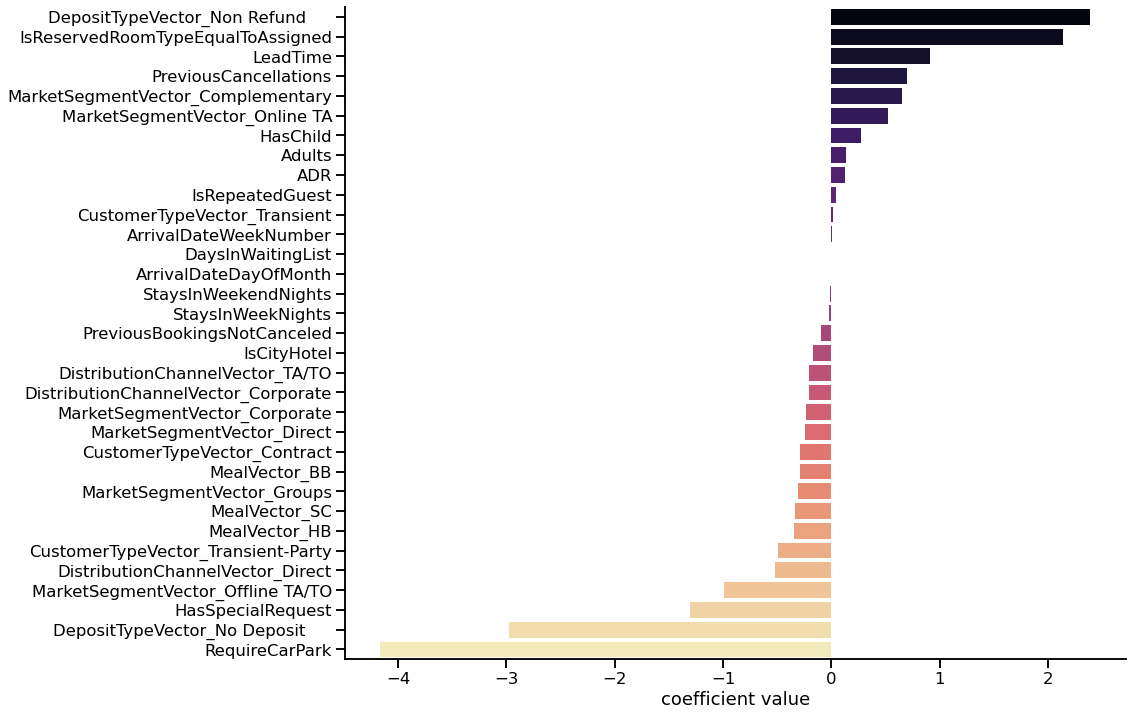

In [28]:
## Extract feature, depends on it is the best model that are loaded from pickled file
## or a newly trained model (still in the form of CrossValidatorModel)

if (type(cv_logres) == pyspark.ml.tuning.CrossValidatorModel):
    feature_value = cv_logres.bestModel.stages[-1].coefficients
elif (type(cv_logres) == pyspark.ml.pipeline.PipelineModel):
    feature_value = cv_logres.stages[-1].coefficients

logres_coef = get_feature_importance_score(
    feature_importance = feature_value,
    spark_df = df_train_assembled,
    feature_colname = 'features'
)
logres_coef['score_abs'] = np.abs(logres_coef['score'])

plot_feature_importance_score(logres_coef, xlabel = 'coefficient value')

### Decision Tree

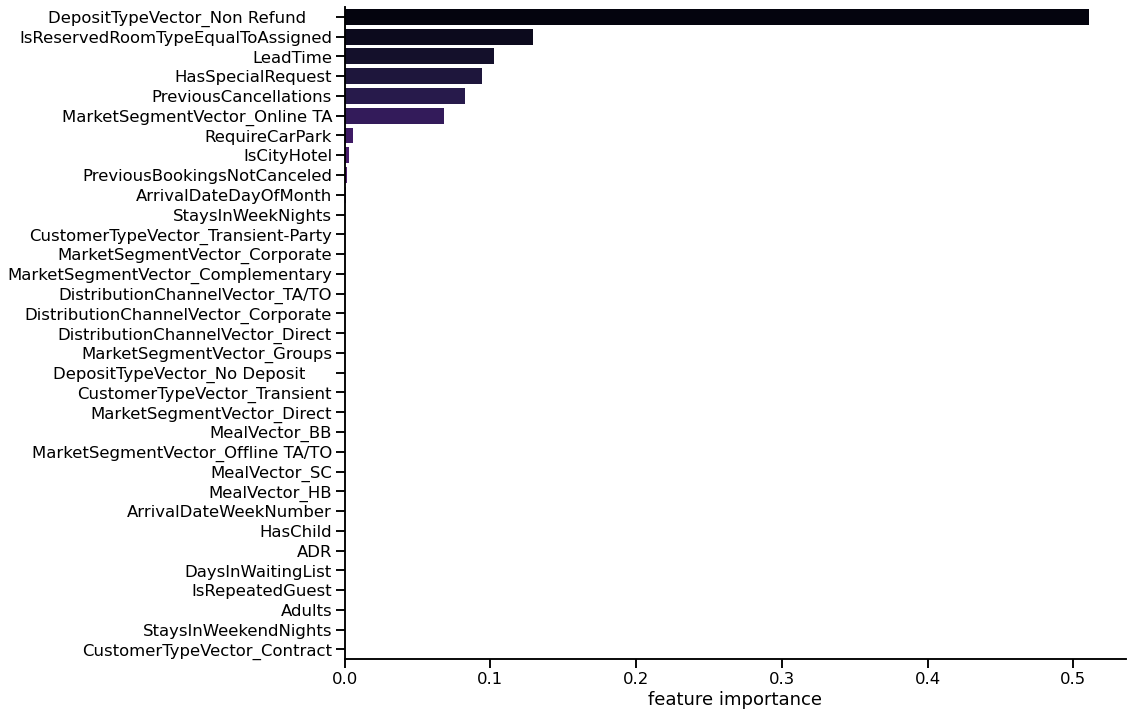

In [29]:
## Extract feature, depends on it is the best model that are loaded from pickled file
## or a newly trained model (still in the form of CrossValidatorModel)

if (type(cv_dtree) == pyspark.ml.tuning.CrossValidatorModel):
    feature_value = cv_dtree.bestModel.stages[-1].featureImportances
elif (type(cv_dtree) == pyspark.ml.pipeline.PipelineModel):
    feature_value = cv_dtree.stages[-1].featureImportances

dtree_features = get_feature_importance_score(
    feature_importance = feature_value,
    spark_df = df_train_assembled,
    feature_colname = 'features'
)

plot_feature_importance_score(dtree_features)

### Random Forest

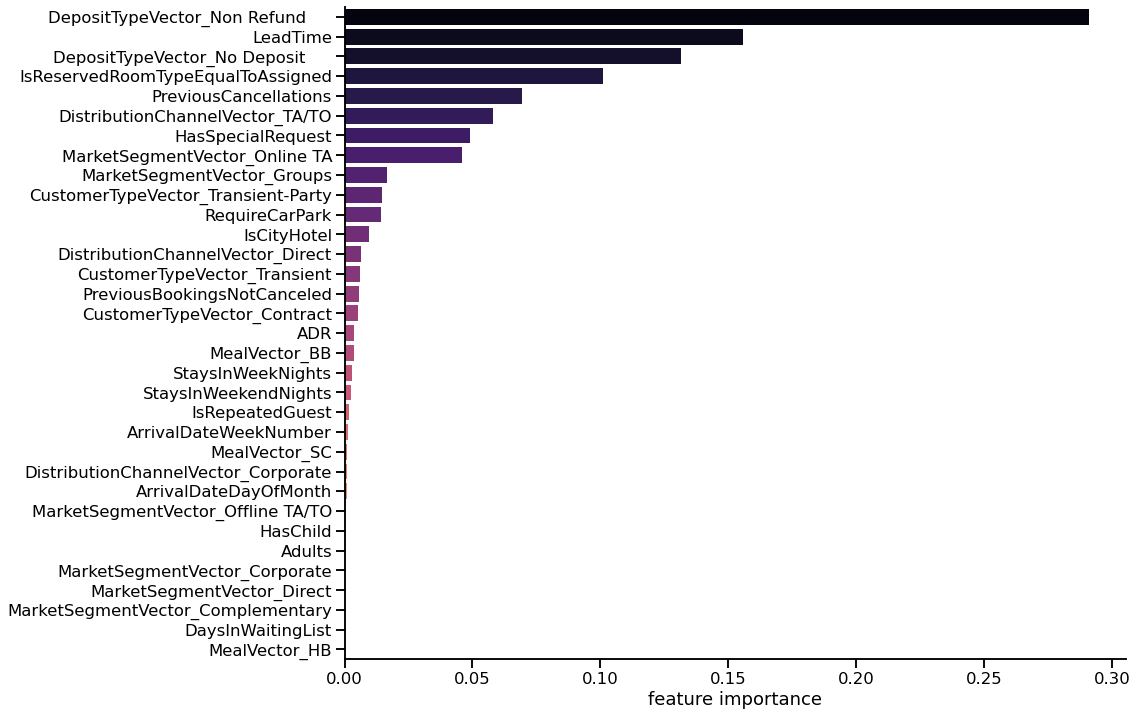

In [30]:
## Extract feature, depends on it is the best model that are loaded from pickled file
## or a newly trained model (still in the form of CrossValidatorModel)

if (type(cv_rf) == pyspark.ml.tuning.CrossValidatorModel):
    feature_value = cv_rf.bestModel.stages[-1].featureImportances
elif (type(cv_rf) == pyspark.ml.pipeline.PipelineModel):
    feature_value = cv_rf.stages[-1].featureImportances

rf_features = get_feature_importance_score(
    feature_importance = feature_value,
    spark_df = df_train_assembled,
    feature_colname = 'features'
)

plot_feature_importance_score(rf_features)

### Gradient Boosted Tree

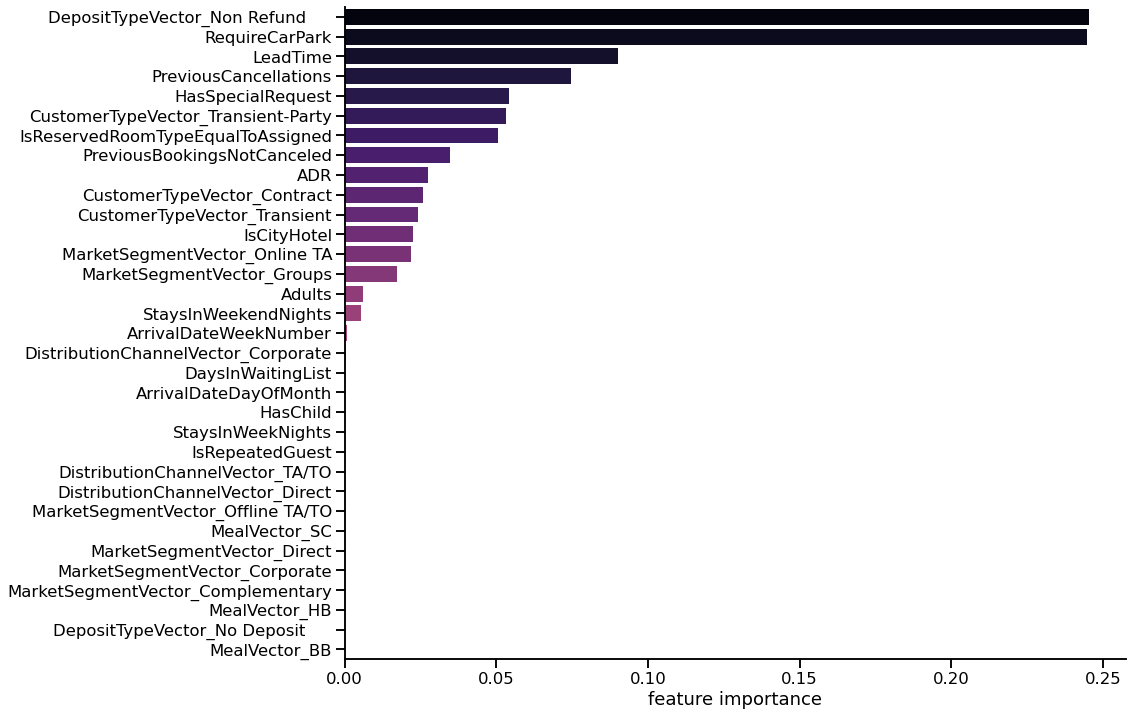

In [31]:
## Extract feature, depends on it is the best model that are loaded from pickled file
## or a newly trained model (still in the form of CrossValidatorModel)

if (type(cv_gbt) == pyspark.ml.tuning.CrossValidatorModel):
    feature_value = cv_gbt.bestModel.stages[-1].featureImportances
elif (type(cv_gbt) == pyspark.ml.pipeline.PipelineModel):
    feature_value = cv_gbt.stages[-1].featureImportances

gbt_features = get_feature_importance_score(
    feature_importance = feature_value,
    spark_df = df_train_assembled,
    feature_colname = 'features'
)

plot_feature_importance_score(gbt_features)

# 8. Interpretation

## 8.1. Study and Discuss the Mined Patterns


We extract the top 5 important features based on each model, as displayed below. There are some intersections of the top features, e.g., LeadTime is considered important in Decision Tree, Random Forest, and GBDT.

In [32]:
TOP_N_FEATURES = 5
FEATURE_NAME_COL = 'name'

logres_top_features = logres_coef.sort_values(
    by = 'score_abs', 
    ascending = False
).head(TOP_N_FEATURES)[FEATURE_NAME_COL].values

df_top_features = pd.DataFrame(
    data = {
        'logistic_regression': logres_top_features,
        'decision_tree': dtree_features.head(TOP_N_FEATURES)[FEATURE_NAME_COL].values,
        'random_forest': rf_features.head(TOP_N_FEATURES)[FEATURE_NAME_COL].values,
        'gbt': gbt_features.head(TOP_N_FEATURES)[FEATURE_NAME_COL].values
    }
)

df_top_features

,logistic_regression,decision_tree,random_forest,gbt
0,RequireCarPark,DepositTypeVector_Non Refund,DepositTypeVector_Non Refund,DepositTypeVector_Non Refund
1,DepositTypeVector_No Deposit,IsReservedRoomTypeEqualToAssigned,LeadTime,RequireCarPark
2,DepositTypeVector_Non Refund,LeadTime,DepositTypeVector_No Deposit,LeadTime
3,IsReservedRoomTypeEqualToAssigned,HasSpecialRequest,IsReservedRoomTypeEqualToAssigned,PreviousCancellations
4,HasSpecialRequest,PreviousCancellations,PreviousCancellations,HasSpecialRequest


There are 7 unique features.

In [33]:
from itertools import chain

top_features = set(chain(*df_top_features.values))
top_features

{'DepositTypeVector_No Deposit     ',
 'DepositTypeVector_Non Refund     ',
 'HasSpecialRequest',
 'IsReservedRoomTypeEqualToAssigned',
 'LeadTime',
 'PreviousCancellations',
 'RequireCarPark'}

## 8.2. Visualise the Data, Results, Models, Patterns

## 8.3. Interpret the Results, Models, Patterns

Cancelled bookings:
- have bimodal ADR distribution
- have longer lead time
- are observed more frequently around the 18th week of year (start of Q2)
- are observed more on Groups market segment
- NOT observed on bookings that require car park
- observed more frequently on customers with more historical booking cancellations

## 8.4. Assess and Evaluate the Results, Models, Patterns